# Conceptual Modeling for User Story
A Capstone Project for Misk Data Science Immersive Course
 
Sarah A. AlQahtani

Dec 6, 2020

<p><img style="float: left;margin:5px 20px 5px 1px" src="img/Unbenanntes_Werk.jpg" width="1000" height="600">




## Introduction

In software engineering, a user story is an informal, natural language description of one or more features of a software system. A user story is a tool used in Agile software development to capture a description of a software feature from an end-user perspective. A user story describes three componants:
- Who wants the functionality
- What functionality the end users or stakeholders want
the system to provide
- Why the end users and stakeholders need this functionality (optional).

In this project we aim at extracting a conceptual model that can staderized the understanding of the requiermens among stakeholders, product owner and development team. The extraction process can be applied with help of the NLP techniques since the input of is a requierments that written in English.To achive this goal, we went through several stages as below:
- Data Collection
- Data Munjing
- Annotating Data
- Train NER Model

---

## Dataset Description
A collection of 22 dataset of more than 50 requierments each a.k.a 'user story'. These were all found online, or retrieved from software companies with a permission to disclose. 

Dataset: https://data.mendeley.com/datasets/7zbk8zsd8y/1

In [242]:
# load the requiered libraries
import math
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
from io import StringIO
import random
import pickle
import csv
import plotly.graph_objects as go
import collections

# Reading PDFs
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
# XML
import os
from xml.etree import ElementTree
# Preprocessing
from cleantext import clean
# Spacy
import spacy
from spacy.symbols import nsubj, VERB
from spacy.symbols import VERB, NOUN
from spacy.matcher import Matcher
import random
from spacy.util import minibatch, compounding

import warnings
#nlkt
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize  

#ploty
from plotly import __version__ 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 

#Word Cloud
from wordcloud import WordCloud, STOPWORDS 
import plotly.figure_factory as ff

#sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import make_pipeline
#textblob
from textblob import TextBlob

In [182]:
init_notebook_mode(connected=True)

Let's see what is inside the files and how are the requierments written

In [30]:
path='/Users/alqahtsa/py_projects/DS_Capstone_Project/user_stories_txt/g02-federalspending.txt'

f=open(path,'r',encoding='windows-1252')
user_story_lines = f.readlines()
for line in user_story_lines:
    print(line)

ï»¿As a Data user, I want to have the 12-19-2017 deletions processed.

As a UI designer, I want to redesign the Resources page, so that it matches the new Broker design styles.

As a UI designer, I want to report to the Agencies about user testing, so that they are aware of their contributions to making Broker a better UX.

As a UI designer, I want to move on to round 2 of DABS or FABS landing page edits, so that I can get approvals from leadership.

As a UI designer, I want to move on to round 2 of Homepage edits, so that I can get approvals from leadership.

As a UI designer, I want to move on to round 3 of the Help page edits, so that I can get approvals from leadership.

As a Developer , I want to be able to log better, so that I can troubleshoot issues with particular submissions and functions.

As a Developer, I want to add the updates on a FABS submission to be modified when the publishStatus changes, so that I know when the status of the submission has changed.

As a DevOps eng

As we can see above that each requierment is written in certin pattern seperated by comma.

**<as a (....), i want (....), so that (....)>**

- **Role:** represent the one who want the functionality.
- **Means:** represent the functionality that the end user ask for.
- **End:** the reason behind the need of the functionality in end user perspective. (optional)

In [25]:
def get_text(full_file):
    '''
    func: get_text(user_story.txt)
    input:user_story.pdf
    output:plain text
    main packages: os
    user_story=get_text(full_file)
    '''
    file1=open(full_file,'r',encoding='windows-1252')
    user_story_lines = file1.readlines()
    user_story2=""
    for line in user_story_lines:
        user_story2=user_story2+str(line)
    user_story22=" ".join(user_story2.split('\n'))
    return user_story22

---

## 1. Data Munging

In every NLP project, text has to go through several stages to be processed, so we can get a better accuracy result of the machine learning model.

Here, we remove unicode characters, urls, emails, numbers, 

In [115]:
def preprocess_text(user_story):
  clean_user_story=clean(user_story,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=True,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=True,                # replace all digits with a special token
    no_currency_symbols=True,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="",
    replace_with_email="",
    replace_with_phone_number="",
    replace_with_number="",
    replace_with_digit="",
    replace_with_currency_symbol="",
    lang="en"                       # set to 'de' for German special handling
    )

  return clean_user_story

## 2. Exploratory Data Analysis

In [33]:
len([file for file in os.listdir(rootdir)]) 


22

There are 22 files that contain user stories.

Here, we are going to calculate some statisical calculation that will haep us to understand the dataset. we'll calculate:
- the number of charechters in every file 
- the number of tokens, 
- number of requierment in each file and 
- the avrage words length in each file.

In [198]:
user_story_f_df=pd.DataFrame(columns=['file_name','us_text','file_len','word_count','us_count','avg_word_len'])
rootdir='/Users/alqahtsa/py_projects/uml_generator/user_stories_txt'
user_stories=''
for subdir, dirs, files in os.walk(rootdir):
    for i,file in enumerate(files):
        filepath = subdir + os.sep + file
        f=open(filepath,'r',encoding='windows-1252')
        user_story_lines = f.readlines()
        for count,line in enumerate(user_story_lines):
            no_req=count
        user_storyf=get_text(filepath)
        clean_user_storyf=preprocess_text(user_storyf)
        avg_word_len=get_avg_word_len(clean_user_storyf)
        user_stories=user_stories+' '+clean_user_storyf


        user_story_f_df.loc[i]=[file,clean_user_storyf,len(clean_user_storyf),len(clean_user_storyf.split()),no_req,avg_word_len]
user_story_f_df

,file_name,us_text,file_len,word_count,us_count,avg_word_len
0,g25-duraspace.txt,"as a repository manager, i want to know all th...",11420,2015,99,4.667990
1,g18-neurohub.txt,"as a system administrator, i want to run a scr...",11837,2199,101,4.383356
2,g26-racdam.txt,"as an archivist, i want to apply a license or ...",11779,2122,99,4.551367
3,g28-zooniverse.txt,"as a user, i want to search and discover music...",6124,1060,59,4.778302
4,g23-archivesspace.txt,"as a researcher, i want to be able to view a f...",4931,875,56,4.636571
5,g03-loudoun.txt,"as a public user, i want to search for informa...",9097,1579,57,4.761875
6,g12-camperplus.txt,"as a camp administrator, i want to be able to ...",7132,1397,54,4.105941
7,g17-cask.txt,"as an app developer, i want to include the cod...",8714,1627,66,4.356484
8,g10-scrumalliance.txt,"as a site member, i want to describe myself on...",12929,2569,96,4.033087
9,g08-frictionless.txt,"as a developer, i want to get a data package i...",9533,1745,66,4.463610


In [56]:
def get_avg_word_len(us):
    #we don't want to calculate the whitespaces
    words=us.split()
    word_len=0
    for word in words:
        word_len=word_len+len(word)
    return word_len/len(words)

### 2.1. Most common words in each file?

<AxesSubplot:xlabel='word'>

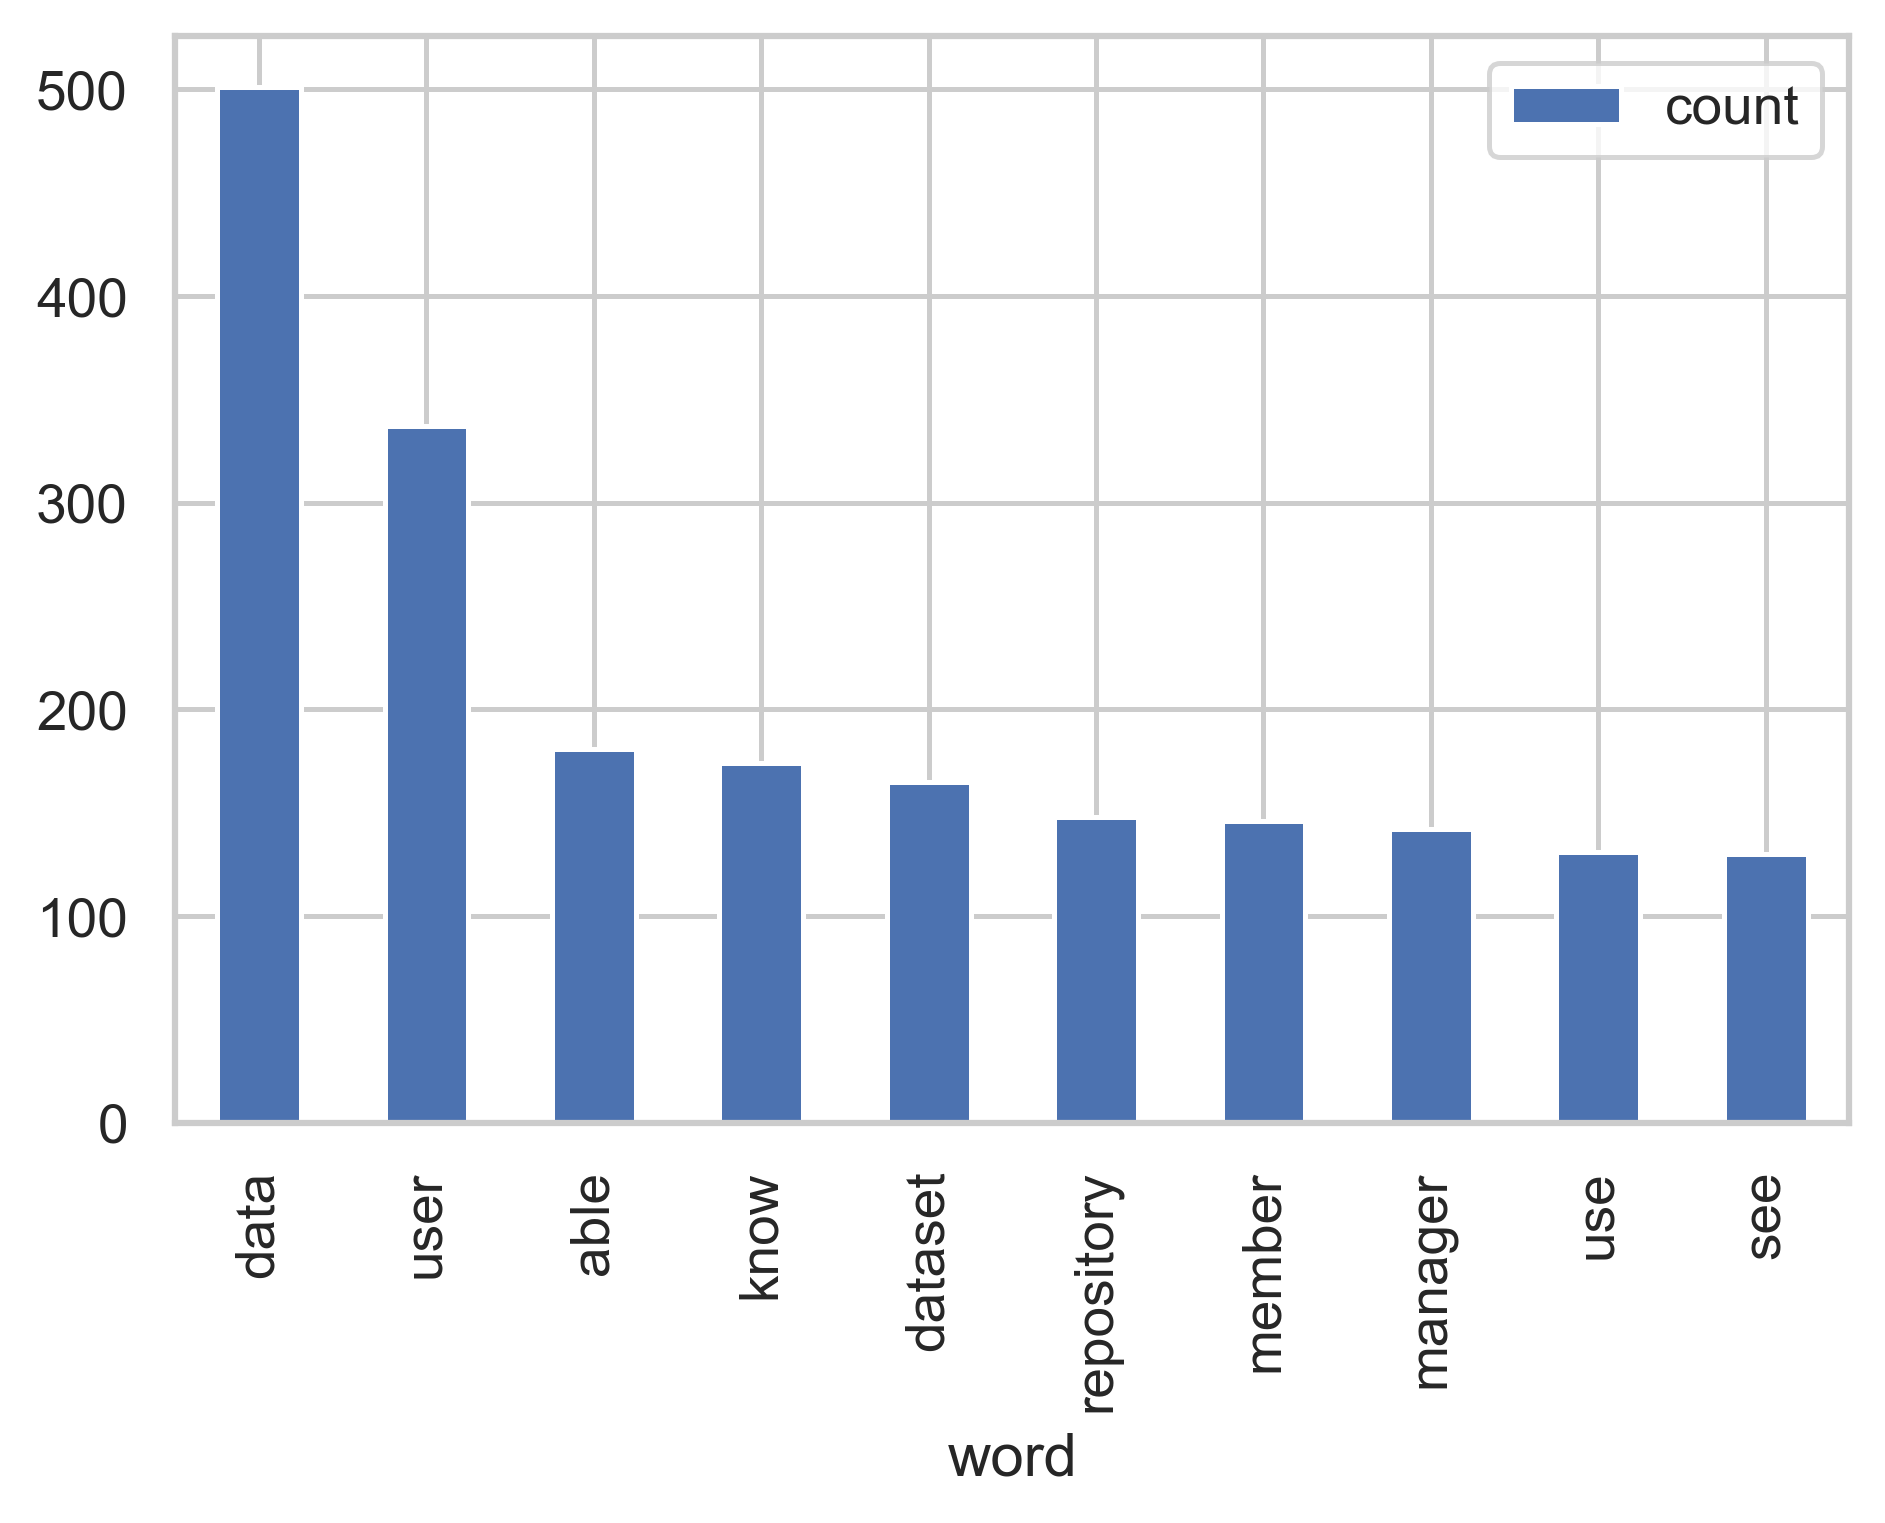

In [184]:

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))  
word_tokens = tokenizer.tokenize(user_stories)  
#filtered_sentence = [count[w] 

count = collections.defaultdict(int)
# stopwords excluded
# also want which in exsists in every user story in the means part
# so that which exsists in every user story in the means part are removed as they stopwords also
filtered_us_txt=''
for w in word_tokens: 
    if not w in stop_words and w!='want':
        filtered_us_txt+=''+w
        count[w]+=1
most_common = sorted(count.items(), key=lambda k_v: k_v[1], reverse=True)[:10]
word_ls=[]
count_ls=[]
for word, i in most_common:
    word_ls.append(word)
    count_ls.append(i)
most_common_df=pd.DataFrame(columns=['word','count'])
most_common_df['word']=word_ls
most_common_df['count']=count_ls
most_common_df.plot.bar(x='word',y='count')

As we can see above, the plot above showing that data

### 2.2. How many requierment in each file?

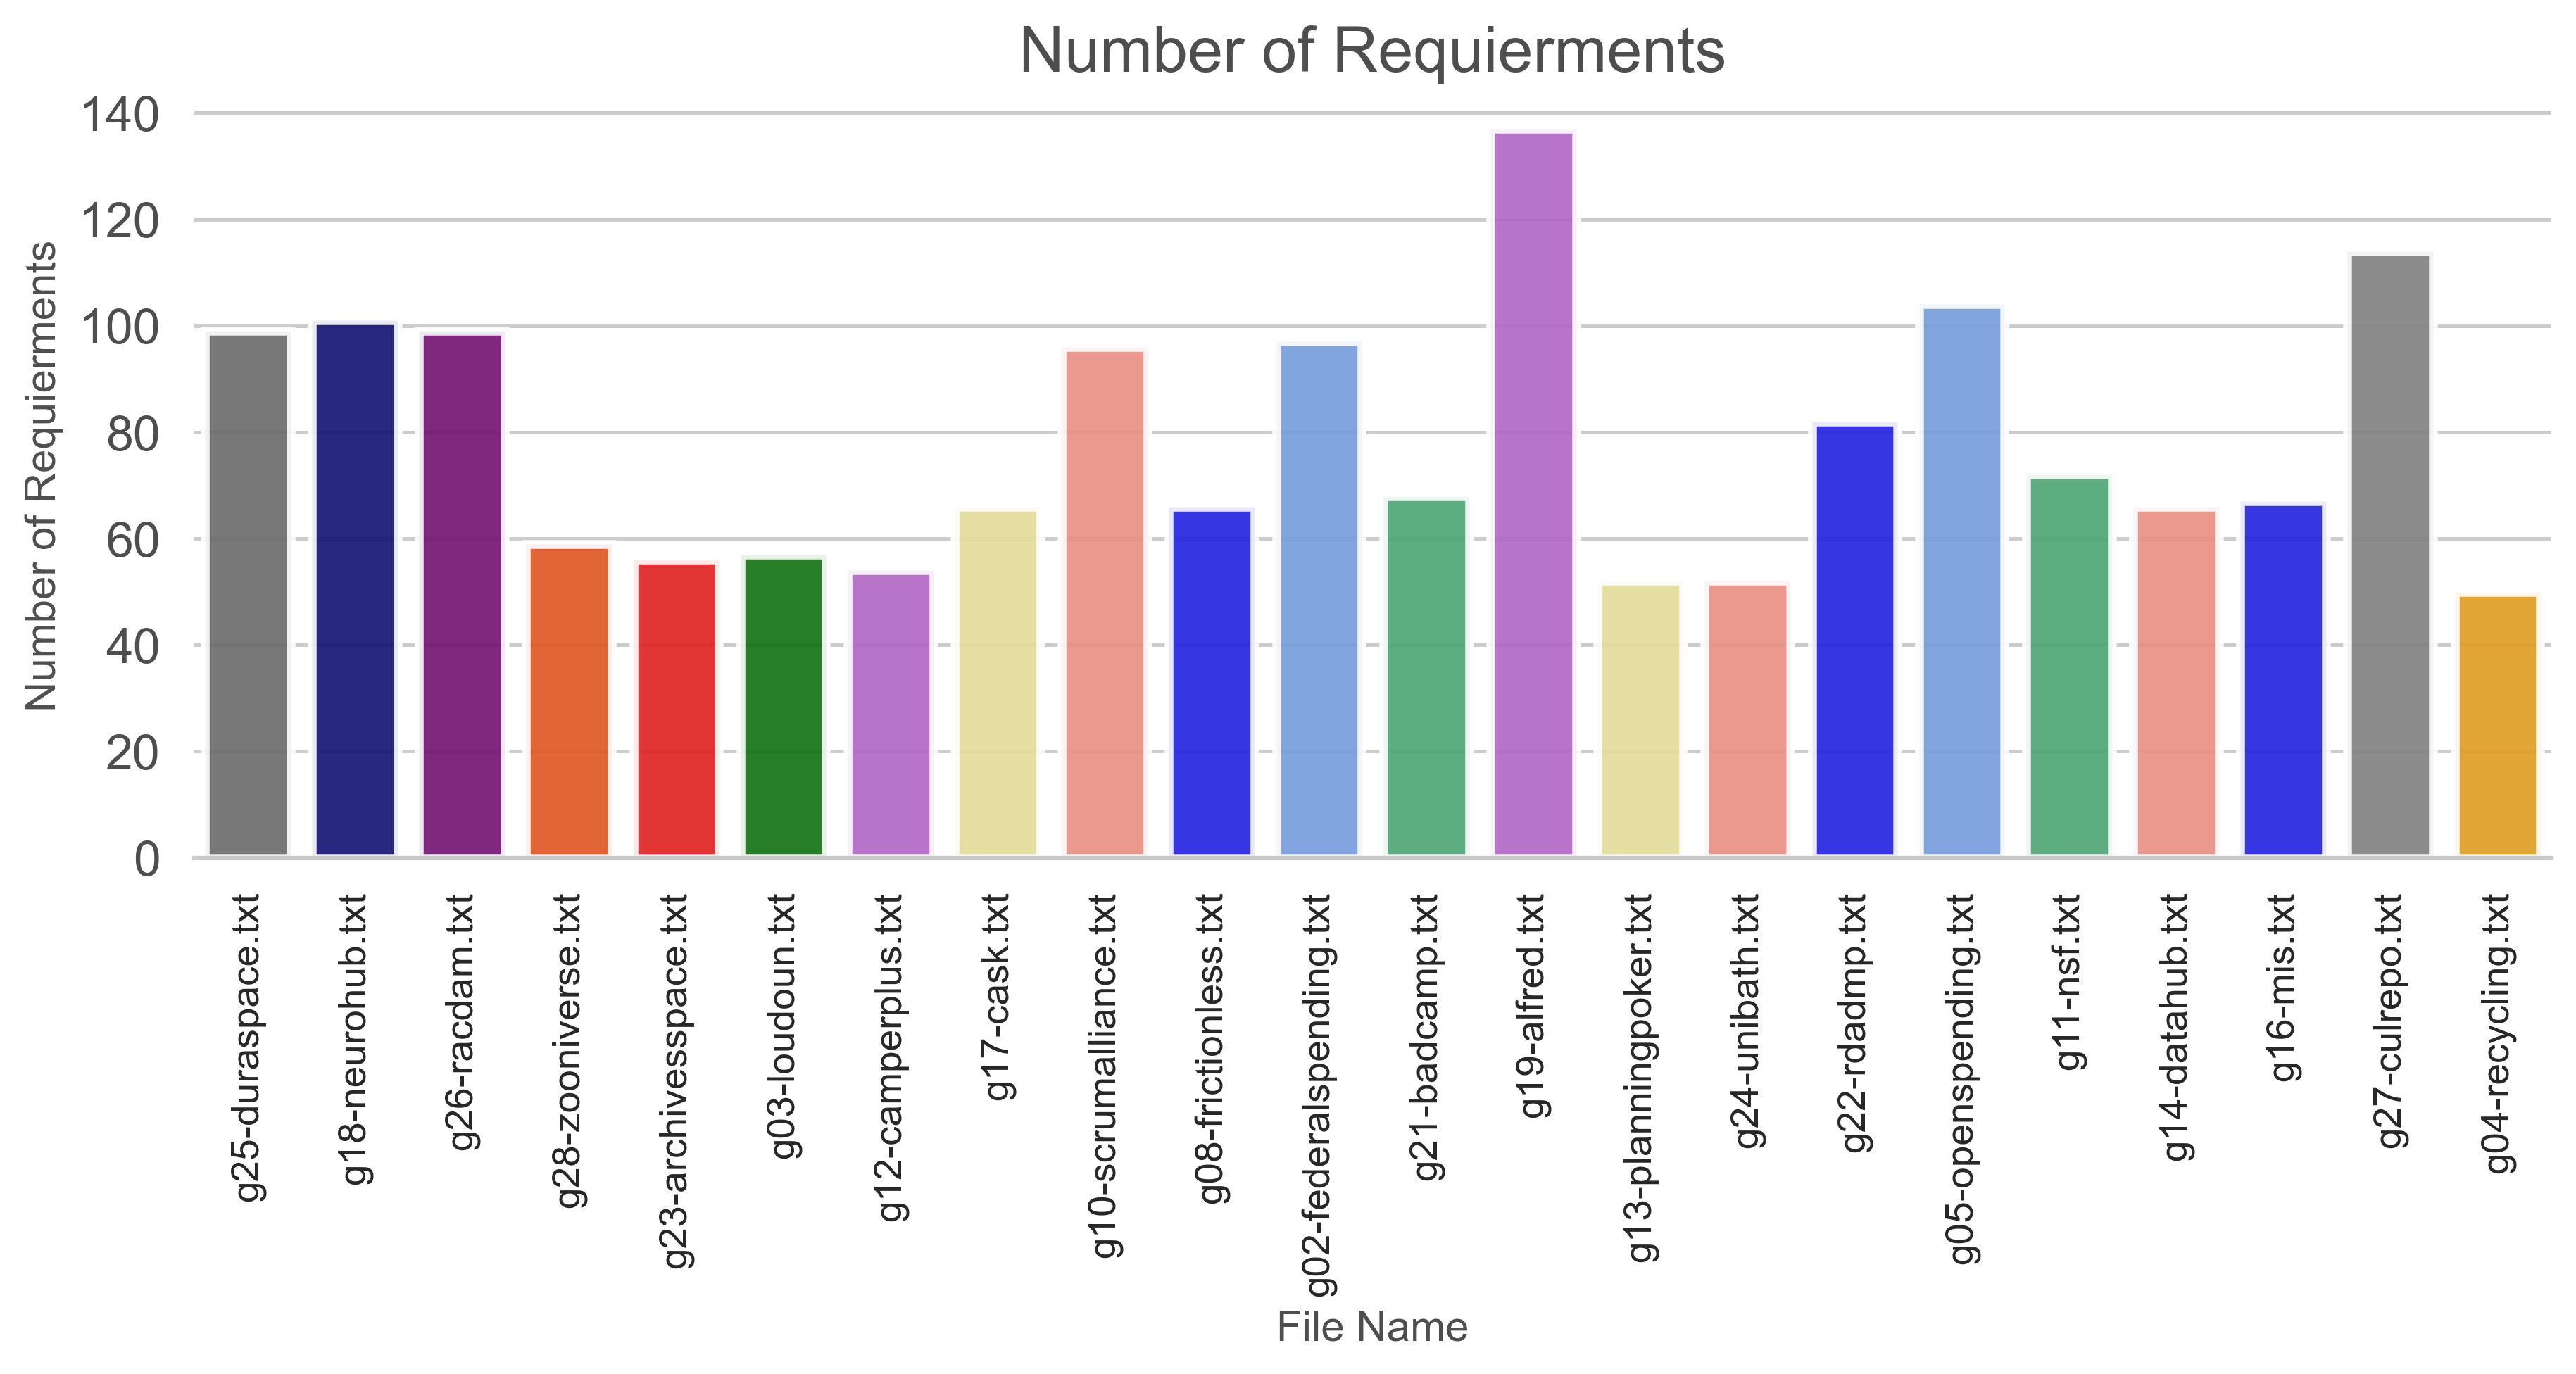

In [172]:
#fig, req_ax = plt.subplots(figsize=())
plt.rcParams['figure.dpi'] = 360
sns.set(style="whitegrid")
fig, req_ax = plt.subplots(figsize=(12,4))
#color = ['dimgray','navy','purple','orangered', 'red', 'green' ,'mediumorchid', 'khaki', 'salmon', 'blue','cornflowerblue','mediumseagreen','mediumorchid', 'khaki', 'salmon', 'blue','cornflowerblue','mediumseagreen','salmon', 'blue','gray','orange']
req_ax=sns.barplot(x='file_name', y='us_count', data=user_story_f_df, palette=color, linewidth=2.5, alpha=0.9)
plt.xlabel("File Name",color='#4f4e4e')
plt.ylabel("Number of Requierments", size=12, color='#4f4e4e')
plt.title("Number of Requierments", size=18, color='#4f4e4e')
#plt.xticks(size=14, color='#4f4e4e')
req_ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.yticks(size=14, color='#4f4e4e')
sns.despine(left=True)

### 2.3. What are there any contiguous sequence of n items?
let's check the top 20 Unigram, Bigram and Trigram

In [211]:
def get_top_ngram(n,text_df,x):
    vec=CountVectorizer(stop_words=stop_words,ngram_range=(n,3)).fit(text_df)
    bow=vec.transform(text_df)
    sum_words=bow.sum(axis=0)
    words_freq=[(word,sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq=sorted(words_freq,key=lambda x:x[1], reverse=True)
    return words_freq[:x]

In [215]:
# Unigram
get_ngram(1,user_story_f_df['us_text'],20)

[('want', 1691),
 ('data', 501),
 ('user', 337),
 ('user want', 256),
 ('able', 181),
 ('know', 174),
 ('want able', 167),
 ('dataset', 165),
 ('repository', 148),
 ('member', 146),
 ('manager', 142),
 ('member want', 135),
 ('manager want', 133),
 ('use', 131),
 ('see', 130),
 ('researcher', 127),
 ('researcher want', 123),
 ('want know', 121),
 ('site', 115),
 ('administrator', 113)]

In [216]:
# Bigram
get_ngram(2,user_story_f_df['us_text'],20)

[('user want', 256),
 ('want able', 167),
 ('member want', 135),
 ('manager want', 133),
 ('researcher want', 123),
 ('want know', 121),
 ('administrator want', 109),
 ('developer want', 109),
 ('archivist want', 100),
 ('olderperson want', 96),
 ('want see', 74),
 ('staff member', 68),
 ('staff member want', 67),
 ('repository manager', 66),
 ('admin want', 65),
 ('repository manager want', 64),
 ('user want able', 57),
 ('manager want know', 52),
 ('want create', 46),
 ('want view', 45)]

In [217]:
# Trigram
get_ngram(3,user_story_f_df['us_text'],20)

[('staff member want', 67),
 ('repository manager want', 64),
 ('user want able', 57),
 ('manager want know', 52),
 ('administrator want able', 36),
 ('camp administrator want', 35),
 ('zooniverse admin want', 33),
 ('dams manager want', 27),
 ('site visitor want', 26),
 ('manager want indicate', 25),
 ('team member want', 25),
 ('olderperson want use', 25),
 ('olderperson want alfred', 25),
 ('faculty member want', 25),
 ('want use alfred', 24),
 ('collection curator want', 24),
 ('agency user want', 23),
 ('library staff member', 22),
 ('object object component', 20),
 ('data manager want', 19)]

### 2.4. What are the Top 20 Part-Of-Speech (POS)?

In [225]:
blob=TextBlob(str(user_story_f_df['us_text']))

In [226]:
blob

TextBlob("0     as a repository manager, i want to know all th...
1     as a system administrator, i want to run a scr...
2     as an archivist, i want to apply a license or ...
3     as a user, i want to search and discover music...
4     as a researcher, i want to be able to view a f...
5     as a public user, i want to search for informa...
6     as a camp administrator, i want to be able to ...
7     as an app developer, i want to include the cod...
8     as a site member, i want to describe myself on...
9     as a developer, i want to get a data package i...
10    as a data user, i want to have the -- deletion...
11    as a anonymoususer, i want to view a list of s...
12    as an olderperson, i want to know exactly what...
13    as a moderator, i want to create a new game by...
14    as a depositor, i want to deposit and maintain...
15    as a pi, i want to properly record all metadat...
16    as a data publishing user, i want to be able t...
17    as a team member, i want to see 

In [232]:
pos_df=pd.DataFrame(blob.tags,columns=['words','pos'])
pos_df=pos_df['pos'].value_counts()

In [233]:
pos_df

NN     80
DT     37
IN     27
VB     24
TO     24
CD     22
VBP    22
JJ      7
CC      3
RB      2
NNS     2
PRP     1
WP      1
Name: pos, dtype: int64

<AxesSubplot:>

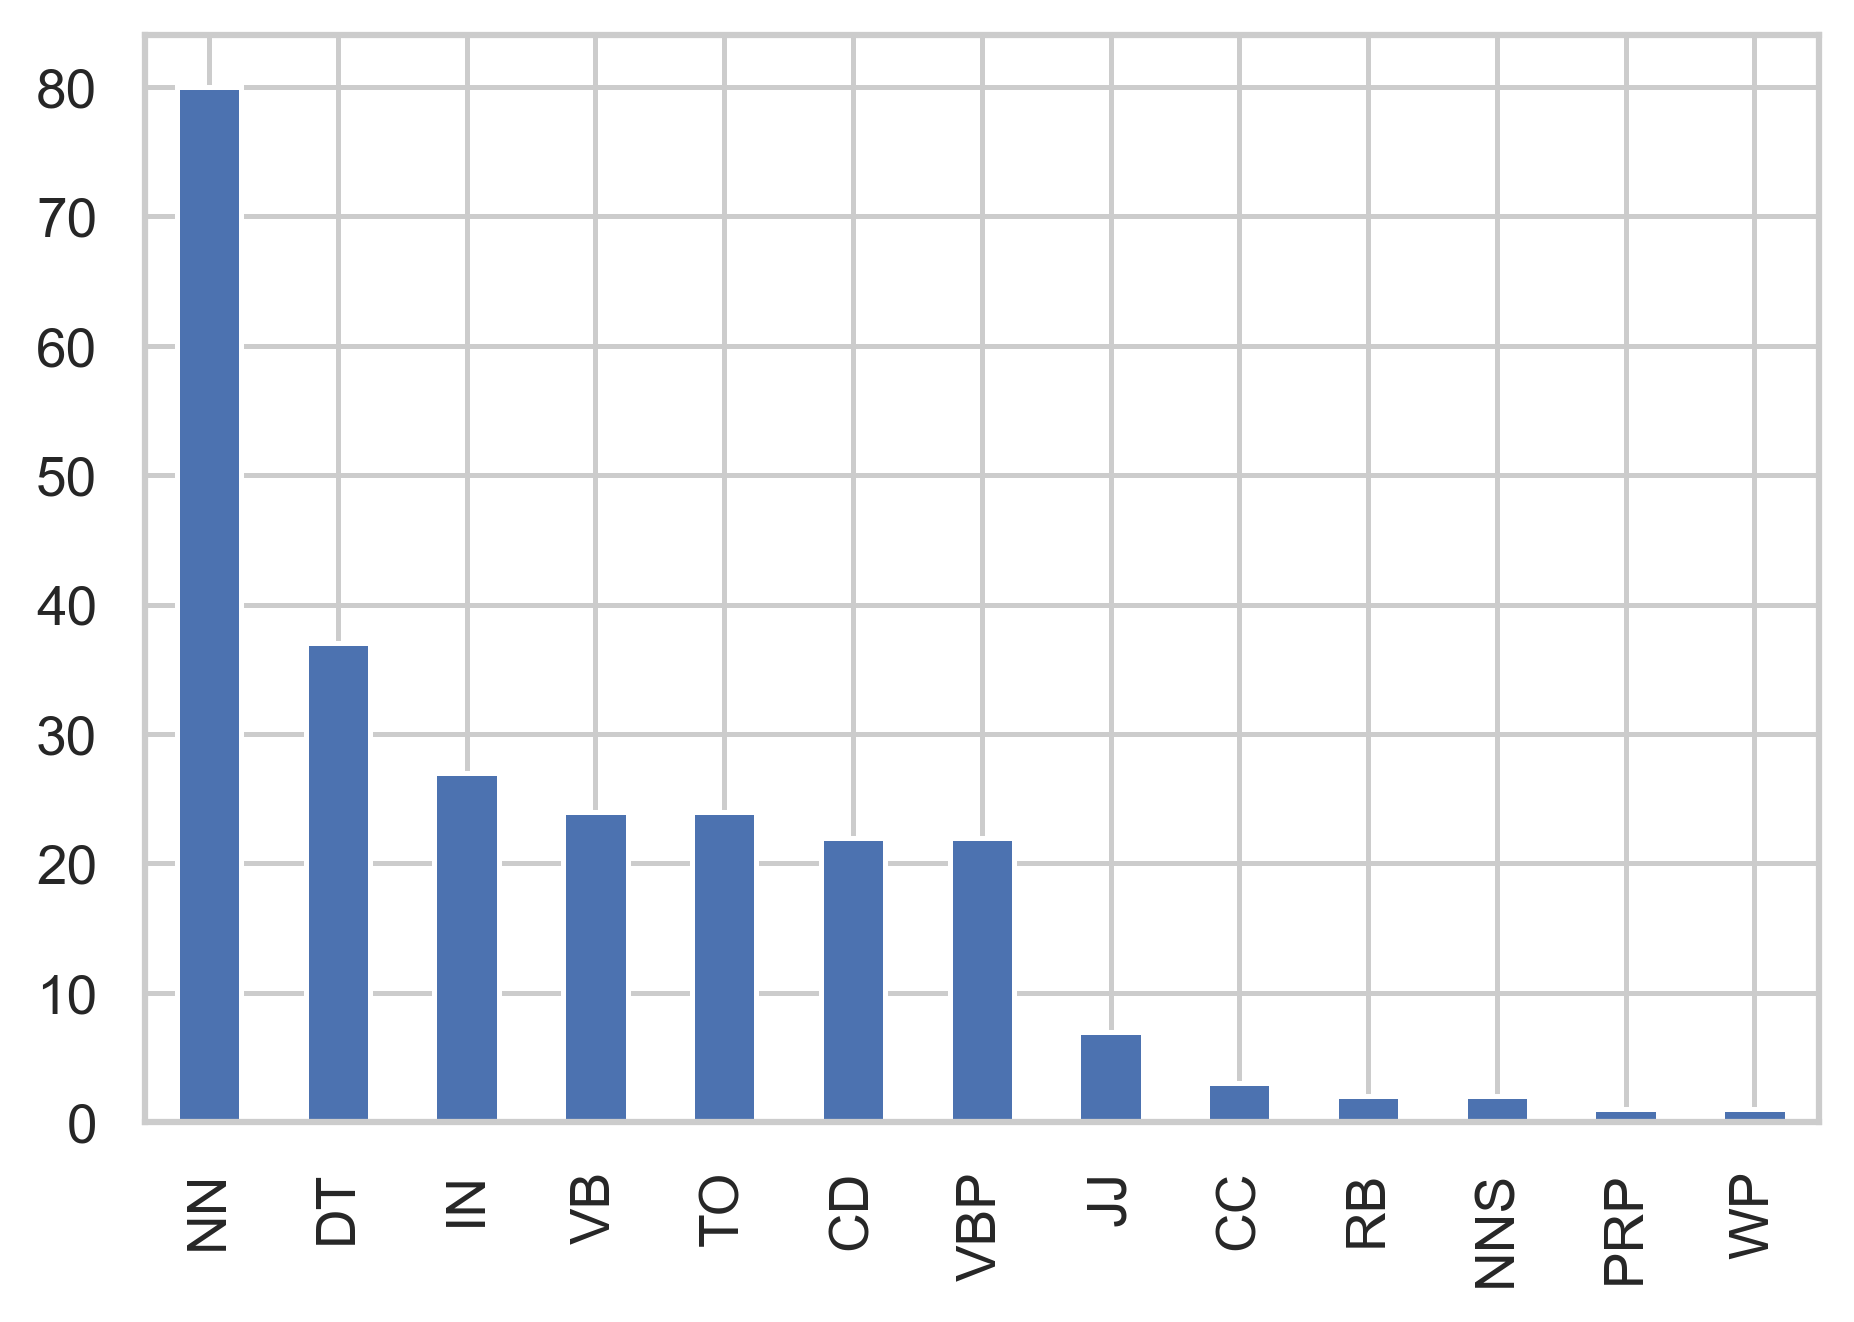

In [238]:

pos_df.plot(kind='bar')


## 3. Annotating Data

At this stage of the project, we implemented a function to annotate the User Story into relations and concepts as below:
- C1. “Every noun is a potential concept.”
- R1. “Every verb is a potential relationship.”
- C2. “A common noun indicates a concept.”
- R2. “A transitive verb indicates a relationship.”
- C3. “The subject of a sentence is a concept.”
- R3. “The verb (phrase) linking the sentence subject and an object forms the relationship between these two.”
- R4. “If a verb is followed by a preposition, then the preposition is included in the relationship name.”
- C4. “Noun compounds are taken together to form a concept.”
- R5. “In noun-noun compounds there is a non-hierarchical relationship between the prefix and compound.”
- H1. “The verb ‘to be’ indicates a hierarchical relationship: the subject is taken as a specialization of the parent object.”
- H2. “If there is a noun-noun compound present, the head of the compound is the parent of the compound concept.”

In [9]:
def annotate_text(clean_user_story):
    rnlp=spacy.load('en_core_web_sm')
    rnlp.add_pipe(rme_custom_sents,before='parser')
    #rme_df=pd.DataFrame(columns=['id','sentence','role','mean','end','start_idx','end_idx','lable','token_text'])
    nlp2=spacy.load('en_core_web_sm')
    #nlp2.add_pipe(custom_sents,before='parser')
    docc=nlp2(clean_user_story)
    rme_df=pd.DataFrame()
    i=0
    id_ls=[]
    sen_ls=[]
    for sent_i,sc in enumerate(docc.sents):
        id_ls.append(sent_i+1)
        sen_ls.append(sc.text.strip('|').strip())
    rme_df['id']=id_ls
    rme_df['sentence']=sen_ls



    ent_df=pd.DataFrame()
    #entities_dic = {} 
    C2_start=[]
    C2_end=[]
    C2_lable=[]
    C2_text=[]
    C2_sent=[]
    c2_matcher=Matcher(nlp2.vocab)
    c2_pattern = [{'POS': 'NOUN'}]
    docc=nlp2(clean_user_story)
    c2_matcher.add('c2_pattern',None,c2_pattern)

    C3_start=[]
    C3_end=[]
    C3_lable=[]
    C3_text=[]
    C3_sent=[]
    c3_matcher=Matcher(nlp2.vocab)
    c3_pattern = [{'DEP': 'nsubj','POS': 'NOUN'}]
    c3_matcher.add('c3_pattern',None,c3_pattern)

    C4_start=[]
    C4_end=[]
    C4_lable=[]
    C4_text=[]
    C4_sent=[]
    c4_matcher=Matcher(nlp2.vocab)
    c4_pattern = [{'DEP': 'compound'}]
    c4_matcher.add('c4_pattern',None,c4_pattern)

    H2_start=[]
    H2_end=[]
    H2_lable=[]
    H2_text=[]
    H2_sent=[]

    R5_start=[]
    R5_end=[]
    R5_lable=[]
    R5_text=[]
    R5_sent=[]
    #for match_id,start,end in c2_matcher(docc):
        #span=docc[start:end]#C2
        #C2_start.append(span.start_char)
        #C2_end.append(span.end_char)
        #C2_lable.append("C2")
        #C2_text.append(span.text)
        #C2_sent.append(span.sent.text)

    for match_id,start,end in c3_matcher(docc):
        span=docc[start:end]#C3
        C3_start.append(span.start_char)
        C3_end.append(span.end_char)
        C3_lable.append("C3")
        C3_text.append(span.text)
        C3_sent.append(span.sent.text)

    ent_df['start_idx']=C3_start+C4_start
    ent_df['end_idx']=C3_end+C4_end
    ent_df['lable']=C3_lable+C4_lable
    #ent_df['text']=C2_text+C3_text+C4_text+H2_text+R5_text
    #ent_df['sentence']=C2_sent+C3_sent+C4_sent+H2_sent+R5_sent
    ent_df
    #temp_df=pd.merge(rme_df, ent_df, on='sentence')
    #temp_df

    rel_df=pd.DataFrame()
    V_start=[]
    V_end=[]
    V_lable=[]
    V_text=[]
    V_sent=[]
    V_matcher=Matcher(nlp2.vocab)
    v_pattern = [{'POS': 'VERB'}]
    #docc=nlp2(clean_user_story)
    V_matcher.add('v_pattern',None,v_pattern)

    Vp_start=[]
    Vp_end=[]
    Vp_lable=[]
    Vp_text=[]
    Vp_sent=[]
    Vp_matcher=Matcher(nlp2.vocab)
    vp_pattern = [{'POS': 'VERB'},
                    {'DEP':'prep'}]
    #docc=nlp2(clean_user_story)
    Vp_matcher.add('vp_pattern',None,vp_pattern)

    dobj_start=[]
    dobj_end=[]
    dobj_lable=[]
    dobj_text=[]
    dobj_sent=[]
    dobj_matcher=Matcher(nlp2.vocab)
    dobj_pattern = [{'DEP': 'dobj', 'POS': 'NOUN'}]
    dobj_matcher.add('dobj_pattern',None,dobj_pattern)

    iobj_start=[]
    iobj_end=[]
    iobj_lable=[]
    iobj_text=[]
    iobj_sent=[]
    iobj_matcher=Matcher(nlp2.vocab)
    iobj_pattern = [{'DEP': 'iobj', 'POS': 'NOUN'}]
    iobj_matcher.add('iobj_pattern',None,iobj_pattern)

    pobj_start=[]
    pobj_end=[]
    pobj_lable=[]
    pobj_text=[]
    pobj_sent=[]
    pobj_matcher=Matcher(nlp2.vocab)
    pobj_pattern = [{'DEP': 'pobj', 'POS': 'NOUN'}]
    pobj_matcher.add('pobj_pattern',None,pobj_pattern)

    for match_id,start,end in V_matcher(docc):
        span=docc[start:end]
        V_start.append(span.start_char)
        V_end.append(span.end_char)
        V_lable.append("R2")
        V_text.append(span.text)
        V_sent.append(span.sent.text)
        #for token in span:
            #if check_verb(token)=='TRANVERB':


            

    #for match_id,start,end in Vp_matcher(docc):
        #   span=docc[start:end]#R4
        #  Vp_start.append(span.start_char)
        # Vp_end.append(span.end_char)
        # Vp_lable.append("R4")
        # Vp_text.append(span.text)
        #Vp_sent.append(span.sent.text)


    for match_id,start,end in dobj_matcher(docc):
        span=docc[start:end]
        dobj_start.append(span.start_char)
        dobj_end.append(span.end_char)
        dobj_lable.append("C2")
        dobj_text.append(span.text)
        dobj_sent.append(span.sent.text)

    for match_id,start,end in pobj_matcher(docc):
        span=docc[start:end]
        pobj_start.append(span.start_char)
        pobj_end.append(span.end_char)
        pobj_lable.append("C2")
        pobj_text.append(span.text)
        pobj_sent.append(span.sent.text)    

    rel_df['start_idx']=V_start+dobj_start+pobj_start
    rel_df['end_idx']=V_end+dobj_end+pobj_start
    rel_df['lable']=V_lable+dobj_lable+pobj_lable
    #rel_df['text']=V_text+Vp_text+dobj_text+pobj_text
    #rel_df['sentence']=V_sent+Vp_sent+dobj_sent+pobj_sent
    #rel_temp_df=pd.merge(rme_df, rel_df, on='sentence')
    #full_df=pd.concat([temp_df,rel_temp_df])
    #full_df=full_df.drop_duplicates()

    full_df1=pd.concat([ent_df,rel_df])
    full_df1=full_df1.drop_duplicates()
    label_ls=[]
    for index,row in full_df1.iterrows():
        label_ls.append((row['start_idx'],row['end_idx'],row['lable']))
    label_dic={}
    label_dic['entities']=label_ls


    return label_dic


In [10]:
def generate_train_data(train_data_tp):
    #train_data_tp=(clean_user_story,labels_dic)
    text_file = open("train_data.txt", "w")
    text_file.write(str(train_data_tp))
    text_file.close()
    return text_file

In [11]:

#splitting data
train_set=math.floor(len([file for file in os.listdir(rootdir)])*.7)# 70% of tha data 

train_data_ls=[]
for subdir, dirs, files in os.walk(rootdir):
    for i,file in enumerate(files):
        if i<train_set:
            filepath = subdir + os.sep + file
            user_story=get_text(filepath)
            clean_user_story=preprocess_text(user_story)
            labels_dic=annotate_text(clean_user_story)
            train_data_tp=(clean_user_story,labels_dic)
            train_data_ls.append((train_data_tp))
generate_train_data(train_data_ls)

<_io.TextIOWrapper name='train_data.txt' mode='w' encoding='UTF-8'>

In [12]:
pkl_file=open('train_data.pkl','wb')
pickle.dump(train_data_ls,pkl_file)
pkl_file.close()


In [13]:
train_data=pickle.load(open('train_data.pkl','rb'))

In [14]:
nlp10=spacy.blank('en')
def train_model(train_data):
    if 'ner' not in nlp10.pipe_names:
        ner=nlp10.create_pipe('ner')
        nlp10.add_pipe(ner,last=True)
    for _,annotation in train_data:
        for ent in annotation['entities']:
            ner.add_label(ent[2])
    # get names of other pipes to disable them during training
    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp10.pipe_names if pipe not in pipe_exceptions]
    # only train NER
    with nlp10.disable_pipes(*other_pipes), warnings.catch_warnings():
        # show warnings for misaligned entity spans once
        warnings.filterwarnings("once", category=UserWarning, module='spacy')

        # reset and initialize the weights randomly – but only if we're
        # training a new model
        
        nlp10.begin_training()
        for itn in range(30):
            random.shuffle(train_data)
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp10.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                )
            print("Losses", losses)

In [15]:
train_model(train_data)


/Users/alqahtsa/opt/anaconda3/lib/python3.8/site-packages/spacy/language.py:635: UserWarning: [W033] Training a new parser or NER using a model with an empty lexeme normalization table. This may degrade the performance to some degree. If this is intentional or this language doesn't have a normalization table, please ignore this warning.
  proc.begin_training(
/Users/alqahtsa/opt/anaconda3/lib/python3.8/site-packages/spacy/language.py:635: UserWarning: [W034] Please install the package spacy-lookups-data in order to include the default lexeme normalization table for the language 'en'.
  proc.begin_training(
Losses {'ner': 26684.57846069336}
Losses {'ner': 19113.793411254883}
Losses {'ner': 11219.069913864136}
Losses {'ner': 10911.942171096802}
Losses {'ner': 10916.95958328247}
Losses {'ner': 10110.30926322937}
Losses {'ner': 9498.654777526855}
Losses {'ner': 8477.914203643799}
Losses {'ner': 8076.770166397095}
Losses {'ner': 7197.0363845825195}
Losses {'ner': 7090.1977071762085}
Losses 

In [17]:
ner_model=spacy.load('ner_model2')

In [18]:
p='/Users/alqahtsa/py_projects/uml_generator/user_stories_txt/g05-openspending.txt'
test_user_story=get_text(p)
test_clean_user_story=preprocess_text(user_story)
tdoc=ner_model(test_clean_user_story)
for ent in tdoc.ents:
    print(f'{ent.label_.upper():{30}}- {ent.text}')

R2                            - want
R2                            - deposit
R2                            - maintain
C2                            - datasets
R2                            - need
R2                            - install
R2                            - learn
C2                            - software
R2                            - deposit
R2                            - want
C2                            - interface
R2                            - feel
R2                            - like
R2                            - joined
R2                            - want
R2                            - deposit
R2                            - maintain
C2                            - datasets
R2                            - managing
C2                            - outputs
R2                            - want
R2                            - deposit
R2                            - maintain
C2                            - datasets
R2                            - continue
R2           

In [3]:
def custom_sents(docx):
    for token in docx[:-1]:
        if token.text=='|':
            docx[token.i].is_sent_start=True
    return docx


In [4]:
def rme_custom_sents(docx):
    for token in docx[:-1]:
        if token.text==',' and docx[token.i+1].text=='i':
            docx[token.i].is_sent_start=True
        elif token.text==',' and docx[token.i+1].text=='so':
            docx[token.i].is_sent_start=True
    return docx

In [5]:
def check_verb(token):
    """Check verb type given spacy token"""
    if token.pos_ == 'VERB':
        indirect_object = False
        direct_object = False
        for item in token.children:
            if(item.dep_ == "iobj" or item.dep_ == "pobj"):
                indirect_object = True
            if (item.dep_ == "dobj" or item.dep_ == "dative"):
                direct_object = True
        if indirect_object and direct_object:
            return 'DITRANVERB'
        elif direct_object and not indirect_object:
            return 'TRANVERB'
        elif not direct_object and not indirect_object:
            return 'INTRANVERB'
        else:
            return 'VERB'
    else:
        return token.pos_